In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils import *
from equations import *

2023-12-05 21:41:22.633049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 21:41:22.816257: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 21:41:22.821313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /totten_1/chenggong/trunk-jpl/externalpackages/proj/install/lib:/totten_1/chenggong

In [2]:
epochADAM = 400000
epochLBFGS = 0
N_u=4000
N_H=4000
N_f=9000
N_C=None
seed=1234
log_frequency=10000
history_frequency=10
NLayers=6
NNeurons=40
noiseLevel=[]
weights = [5,3,5,8,14]

In [3]:
hp = {}
# Data size on the solution u
hp["N_u"] = N_u
hp["N_s"] = N_u
hp["N_H"] = N_H
hp["N_C"] = N_C
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = N_f
# DeepNN topology (2-sized input [x,y], NLayers hidden layer of NNeurons-width, 1-sized output [u,v]
hp["layers"] = [2]+[NNeurons]*NLayers+[2]
# DeepNN topology (1-sized input [x,y], NLayers hidden layer of NNeurons-width, 2-sized output [h, H]
hp["h_layers"] = [2]+[NNeurons]*NLayers+[2]
# DeepNN topology (1-sized input [x,y], NLayers hidden layer of NNeurons-width, 1-sized output [C]
hp["C_layers"] = [2]+[NNeurons]*NLayers+[1]
# DeepNN topology (1-sized input [x], NLayers hidden layer of NNeurons-width, 4-sized input [u,v,C], 
#   1-sized output [taub]
hp["friction_layers"] = [4]+[NNeurons]*NLayers+[1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = epochADAM
hp["tf_lr"] = 0.001
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = epochLBFGS
hp["log_frequency"] = log_frequency
# Record the history
hp["save_history"] = True
hp["history_frequency"] = history_frequency

# path for loading data and saving models
repoPath = "./"
appDataPath = os.path.join(repoPath, "matlab_SSA", "DATA")
# path = os.path.join(appDataPath, "Helheim_Big_PINN_obs_ITSLIVE0.mat")
# path = os.path.join(appDataPath, "Helheim_Weertman_iT080_PINN_fastflow_CF_1500.mat")
# path = os.path.join(appDataPath, "Helheim_Weertman_iT080_PINN_fastflow_fl.mat")
path = os.path.join(appDataPath, "Helheim_Weertman_iT080_PINN_fastflow_CF.mat")



# modelPath = './Models/SSA2D_3NN_test_NH2000_3NN_6x20_weights5_3_5_10_16_20231111_082315'
# modelPath = './Models/SSA2D_3NN_test_NH1000_3NN_6x20_weights5_3_5_10_16_20231111_025930'
# modelPath = './Models/SSA2D_3NN_test_NH500_3NN_6x20_weights5_3_5_10_16_20231110_213928'
# modelPath = './Models/SSA2D_3NN_test_NH250_3NN_6x20_weights5_3_5_10_16_20231110_161914'
# modelPath = './Models/SSA2D_3NN_knowningC_3NN_6x20_weights5_3_5_10_16_20231113_142344'
# modelPath = './Models/SSA2D_knowningC_3NN_6x20_weights5_3_5_10_16_20231113_210249'
# modelPath = './Models/SSA2D_3NN_fl_3NN_6x20_weights5_3_5_10_16_20231113_190344'
# modelPath = './Models/SSA2D_3NN_test_NH125_3NN_6x20_weights5_3_5_10_16_20231114_162319'
# modelPath = './Models/SSA2D_Rignot2012_3NN_6x20_weights5_3_5_10_16_20231115_081042'
# modelPath = './Models/SSA2D_FlightTrackH250_3NN_6x20_weights5_3_5_8_14_20231127_152002'
modelPath = './Models_Kubeflow/2D/SSA2D_FlightTrackH_3NN_6x20_weights5_3_5_8_14_20231124_175437/'


reloadModel = True
weights = [5, 3, 5, 10, 16]
loss_weights = [10**(-w) for w in weights]


In [4]:
x, y, Exact_vx, Exact_vy, X_star, u_star, X_u_train, u_train, X_f, X_bc, u_bc, X_cf, n_cf, xub, xlb, uub, ulb, mu = prep_2D_data_all(path, N_f=hp["N_f"], N_u=hp["N_u"], N_s=hp["N_s"], N_H=hp["N_H"], N_C=hp["N_C"],FlightTrack=True) #}}}

Use 1347 flight track data for the ice thickness training data


In [5]:
X_u_train['H'].shape

(1889, 2)

In [6]:
logger = Logger(hp)
pinn = SSA_3NN(hp, logger, X_f,
            X_cf, n_cf,
            xub, xlb, uub, ulb,
            modelPath, reloadModel,
            mu=mu,
            loss_weights=loss_weights)

Hyperparameters:
{
  "N_u": 4000,
  "N_s": 4000,
  "N_H": 4000,
  "N_C": null,
  "N_f": 9000,
  "layers": [
    2,
    40,
    40,
    40,
    40,
    40,
    40,
    2
  ],
  "h_layers": [
    2,
    40,
    40,
    40,
    40,
    40,
    40,
    2
  ],
  "C_layers": [
    2,
    40,
    40,
    40,
    40,
    40,
    40,
    1
  ],
  "friction_layers": [
    4,
    40,
    40,
    40,
    40,
    40,
    40,
    1
  ],
  "tf_epochs": 400000,
  "tf_lr": 0.001,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "nt_epochs": 0,
  "log_frequency": 10000,
  "save_history": true,
  "history_frequency": 10
}

TensorFlow version: 2.11.0
Eager execution: True
GPU-accerelated: []


2023-12-05 21:41:29.278361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /totten_1/chenggong/trunk-jpl/externalpackages/proj/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/netcdf/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/petsc/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/hdf5/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/gdal/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/triangle/install/lib:/totten_1/chenggong/Elmer/install/lib:
2023-12-05 21:41:29.278405: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-05 21:41:29.278441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (totten): /proc/driver/n

In [7]:
pinn.model.layers[-1].weights

[<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([-5.34427584e-06, -1.52559958e-04])>,
 <tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([2.25062120e-04, 2.24363605e-05])>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>]

In [8]:
pinn.h_model.layers[-1].weights

[<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([-869.43658111,   10.        ])>,
 <tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([1557.59447316, 1697.85587112])>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>]

In [8]:
yts = 3600*24*365
X, Y = np.meshgrid(np.linspace(xlb[0],xub[0],200), np.linspace(xlb[1],xub[1], 200))

# obs
u_obs = yts*griddata(X_star, u_star[:,0].flatten(), (X, Y), method='cubic')
v_obs = yts*griddata(X_star, u_star[:,1].flatten(), (X, Y), method='cubic')
s_obs = griddata(X_star, u_star[:,2].flatten(), (X, Y), method='cubic')
H_obs = griddata(X_star, u_star[:,3].flatten(), (X, Y), method='cubic')
C_obs = griddata(X_star, u_star[:,4].flatten(), (X, Y), method='cubic')
icemask = ((s_obs<0) + (np.isnan(s_obs)))

# interpolations
H_interp = griddata(X_u_train['H'], u_train['H'].flatten(), (X, Y), method='cubic')
C_interp = griddata(X_u_train['C'], u_train['C'].flatten(), (X, Y), method='cubic')

In [9]:
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

In [11]:
# predicted solution
u_pred, v_pred, s_pred, H_pred, C_pred = pinn.predict(X_nn)
u_nn = np.reshape(u_pred, X.shape)*yts
v_nn = np.reshape(v_pred, X.shape)*yts
s_nn = np.reshape(s_pred, X.shape)
H_nn = np.reshape(H_pred, X.shape)
C_nn = np.reshape(C_pred, X.shape)

In [12]:
###########################
plotData = {}
plotData['u obs'] = np.sqrt(u_obs**2+v_obs**2)
plotData['s obs'] = s_obs
plotData['H obs'] = H_obs
plotData['C obs'] = C_obs
###########################
vel = np.sqrt(u_nn**2+v_nn**2)
plotData['u'] = vel
plotData['s'] = s_nn
plotData['H'] = np.abs(H_nn)
plotData['C'] = np.abs(C_nn)
###########################
plotData['u - uobs'] =  plotData['u'] - plotData['u obs']
plotData['s - sobs'] = plotData['s'] - plotData['s obs']
plotData['H - Hobs'] = plotData['H'] - plotData['H obs']
plotData['C - Cobs'] = plotData['C'] - plotData['C obs']
###########################
plotData['H interp'] = H_interp
plotData['Hinterp - Hobs'] = plotData['H interp'] - plotData['H obs']
plotData['H - Hinterp'] = plotData['H'] - plotData['H interp']
plotData['Training data'] = 0*H_obs

# set ice mask
for k in plotData.keys():
    plotData[k][icemask] = np.nan

In [16]:
for k in plotData.keys():
    print(k + ": " + str(np.nanmean(np.abs(plotData[k]))))
    print(k + ": " + str(np.nanstd((plotData[k]))))

u obs: 1230.4907135761239
u obs: 1613.217572443694
s obs: 898.1750622921859
s obs: 410.96199253035815
H obs: 603.2885984733315
H obs: 386.87573385076513
C obs: 2491.771495543801
C obs: 937.8517722779186
u: 1231.3689033036017
u: 1598.6786214928068
s: 898.0850326095363
s: 410.5675886626697
H: 612.7145423588805
H: 398.2492735586726
C: 2301.6586095399466
C: 980.8892531941399
u - uobs: 75.34377536762604
u - uobs: 124.91994630023562
s - sobs: 14.784235859842198
s - sobs: 22.035774012543413
H - Hobs: 52.99725025477654
H - Hobs: 87.84176309247832
C - Cobs: 549.2766519362311
C - Cobs: 879.2532352828887
H interp: 628.1169398105953
H interp: 415.1997877946945
Hinterp - Hobs: 70.1614729354932
Hinterp - Hobs: 111.55676971972188
H - Hinterp: 43.650033577261894
H - Hinterp: 83.7053039960044
Training data: 0.0
Training data: 0.0


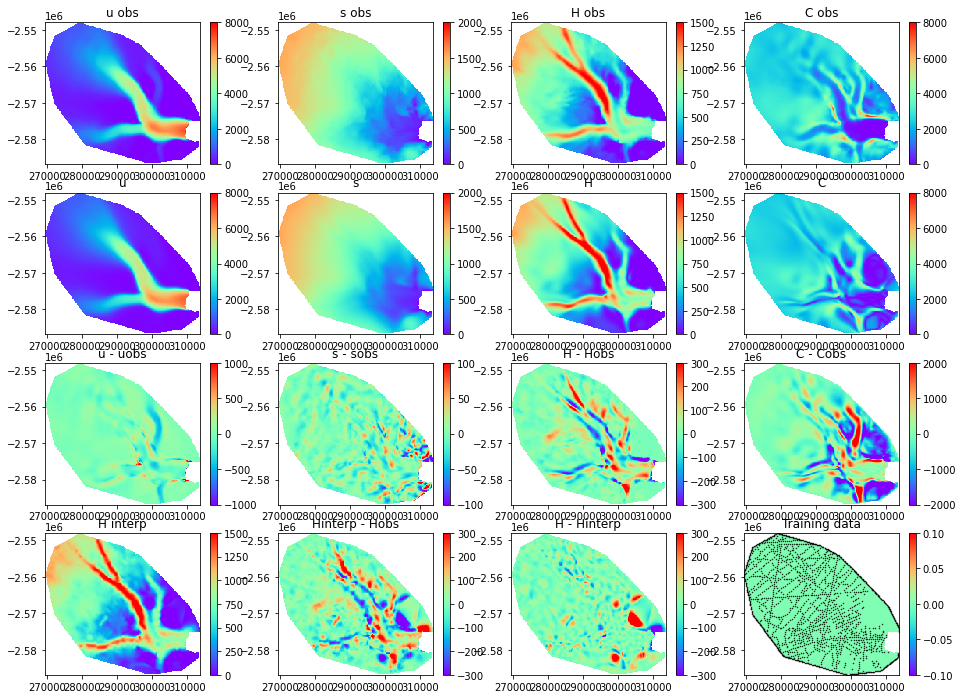

In [17]:
vranges={'u obs': [0,8e3], 'u': [0,8e3], 'u - uobs':[-1e3,1e3], 
         'H':[0,1500], 'H obs':[0,1500],'H interp':[0,1500], 
         'H - Hobs':[-0.3e3,0.3e3], 'Hinterp - Hobs':[-0.3e3,0.3e3], 'H - Hinterp':[-0.3e3,0.3e3],
         'C':[0,8e3], 'C obs':[0,8e3],'C - Cobs':[-2e3,2e3],
         's - sobs':[-100,100], 's':[0,2000], 's obs':[0,2000]
      }
fig, axs = plt.subplots(4, 4 , figsize=(16,12))

for ax,name in zip(axs.ravel(), plotData.keys()):
    vr = vranges.setdefault(name, [None, None])
    im = ax.imshow(plotData[name], interpolation='nearest', cmap='rainbow',
            extent=[X.min(), X.max(), Y.min(), Y.max()],
            vmin=vr[0], vmax=vr[1],
            origin='lower', aspect='auto')
    ax.set_title(name)
    fig.colorbar(im, ax=ax, shrink=1)
    if name =='Training data':
        ax.scatter(X_u_train['H'][:,0:1],X_u_train['H'][:,1:2],0.2,'black')
#         ax.scatter(X_u_train['C'][:,0:1],X_u_train['C'][:,1:2],1,'red')
        ax.set_xlim(X.min(), X.max())
        ax.set_ylim(Y.min(), Y.max())

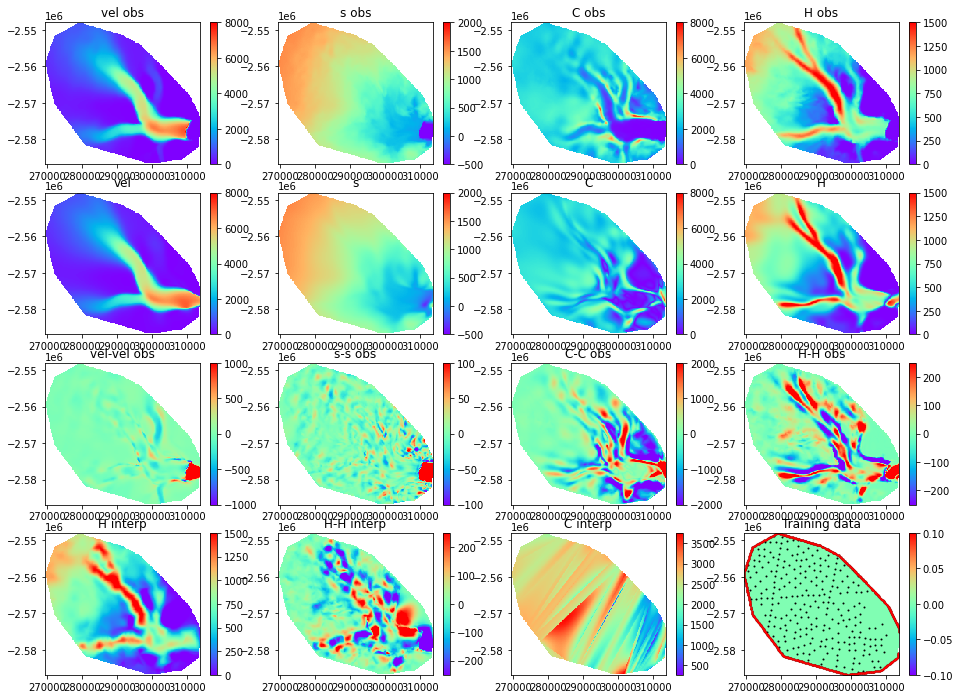

In [12]:
    vranges={'vel obs': [0,8e3], 'vel': [0,8e3], 'vel-vel obs':[-1e3,1e3], 
             'H':[0,1500], 'H obs':[0,1500],'H interp':[0,1500], 
             'H-H obs':[-0.25e3,0.25e3],'H-H interp':[-0.25e3,0.25e3], 
             'C':[0,8e3], 'C obs':[0,8e3],'C-C obs':[-2e3,2e3],
             's-s obs':[-100,100], 's':[-500,2000], 's obs':[-500,2000]
          }
    ###########################
    plotData = {}
    plotData['vel obs'] = np.sqrt(ux**2+uy**2)
    plotData['s obs'] = h_obs
    plotData['C obs'] = C_obs
    plotData['H obs'] = H_obs
    ###########################
    vel = np.sqrt(u_nn**2+v_nn**2)
    plotData['vel'] = vel
    plotData['s'] = h_nn
    plotData['C'] = np.abs(C_nn)
    plotData['H'] = np.abs(H_nn)
    ###########################
    plotData['vel-vel obs'] =  plotData['vel'] -  plotData['vel obs'] 
    plotData['s-s obs'] = h_nn - h_obs
    plotData['C-C obs'] = plotData['C'] - C_obs
    plotData['H-H obs'] = plotData['H'] - H_obs
    plotData['H interp'] = H_interp
    plotData['H-H interp'] = (H_obs - H_interp)
    plotData['C interp'] = C_interp
    plotData['Training data'] = 0*H_obs

#     flagthin = (vel<2000)
#     plotData['H-H interp'][flagthin] = 0
#     plotData['H-H obs'][flagthin] = 0
    
    fig, axs = plt.subplots(4, 4 , figsize=(16,12))

    for ax,name in zip(axs.ravel(), plotData.keys()):
        vr = vranges.setdefault(name, [None, None])
        im = ax.imshow(plotData[name], interpolation='nearest', cmap='rainbow',
                extent=[X.min(), X.max(), Y.min(), Y.max()],
                vmin=vr[0], vmax=vr[1],
                origin='lower', aspect='auto')
        ax.set_title(name)
        fig.colorbar(im, ax=ax, shrink=1)
        if name =='Training data':
            ax.scatter(X_u_train['H'][:,0:1],X_u_train['H'][:,1:2],1,'black')
            ax.scatter(X_u_train['C'][:,0:1],X_u_train['C'][:,1:2],1,'red')
            ax.set_xlim(X.min(), X.max())
            ax.set_ylim(Y.min(), Y.max())